In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})
%matplotlib widget


In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

In [3]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]

MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolError= MapDebPolError.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()

######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan

Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan


Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
# BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

# plt.figure()
# plt.imshow(BlankedMapStokesI.data,origin='lower',vmin = 1,vmax = 45)
# plt.show()

Filename: ../FITS_file/CygX_E_OTFMAP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1095   (110, 93)   float64   
  1  ERROR I       1 ImageHDU        19   (110, 93)   float64   
  2  STOKES Q      1 ImageHDU        19   (110, 93)   float64   
  3  ERROR Q       1 ImageHDU        19   (110, 93)   float64   
  4  STOKES U      1 ImageHDU        19   (110, 93)   float64   
  5  ERROR U       1 ImageHDU        19   (110, 93)   float64   
  6  IMAGE MASK    1 ImageHDU        35   (110, 93)   float64   
  7  PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
 10  POL ANGLE     1 ImageHDU        19   (110, 93)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 13  POL FLUX      1 

C:\Users\DELL\AppData\Local\Temp\ipykernel_2732\1235764754.py:20: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_2732\1235764754.py:24: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_2732\1235764754.py:28: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


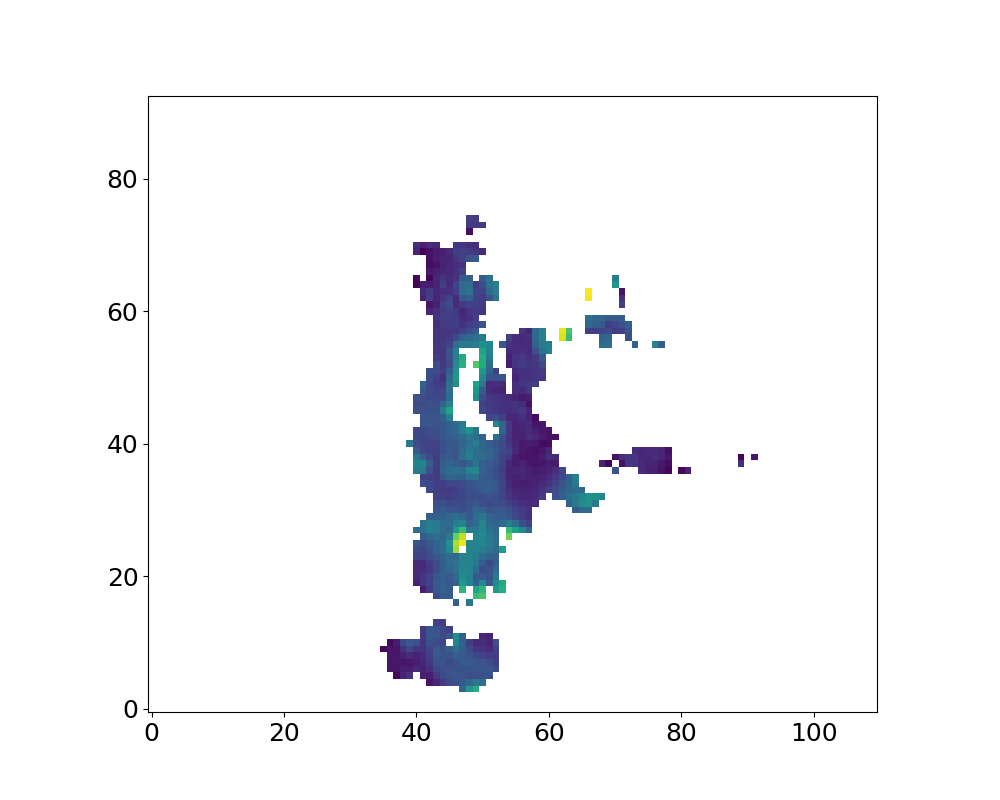

In [4]:
set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S

S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

plt.figure(figsize=(10,8))
plt.imshow(S_map_deb.data,origin='lower')
plt.show()

# set_delta = 0.5   # in arcminute
# S_map = BlankedMapPolAngle.copy()
# sigma_S_map = BlankedMapPolAngleError.copy()

# for i in range(RA_grid.shape[0]):
#     for j in range(RA_grid.shape[1]):

#         ##### seperation filter
#         seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
#         seperation_selector = (seperation.data<0.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data>1.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data >0)

#         ##### making the dispersion map
#         tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
#         tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
#         AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
#         S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
#         S_map.data[i,j] = S

#         ##### making the dispersion error map
#         N = np.sum(~np.isnan(seperation.data))
#         temp1 = ( ( BlankedMapPolAngleError.data[i,j]/( S_map.data[i,j]*N ) )**2)*(np.nansum(AngleDiff_v2[seperation_selector])**2)
#         temp2 = (BlankedMapPolAngleError.data*AngleDiff_v2)
#         temp3 = (( 1 /(S_map.data[i,j]*N) )**2)*( np.nansum( (temp2[seperation_selector])**2 ) )

#         sigma_S =  temp1 + temp3
#         sigma_S_map.data[i,j] = np.sqrt(sigma_S)
        
#         # np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
#         # sigma_S_map.data[i,j] = sigma_S

# S_map_deb = S_map.copy()
# S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

# plt.figure(figsize=(10,8))
# plt.imshow(sigma_S_map.data,origin='lower')
# plt.show()


synthetic data for dispersion 


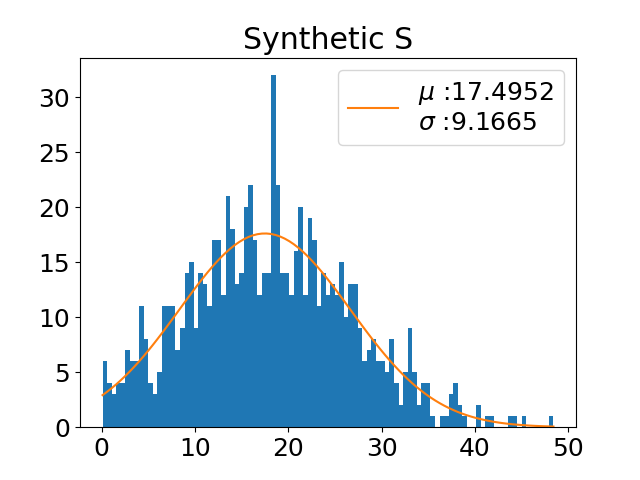

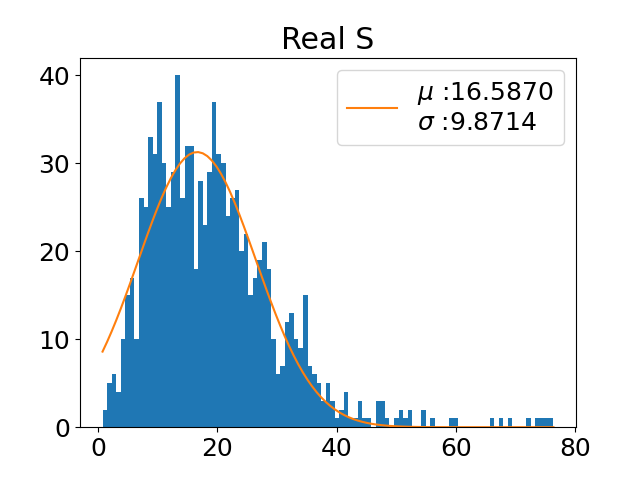

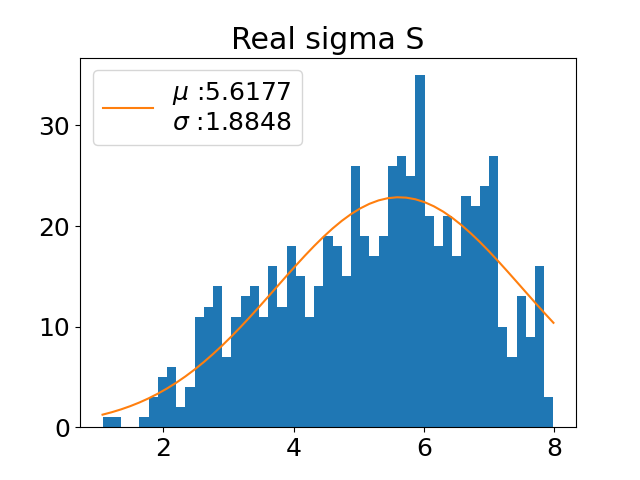

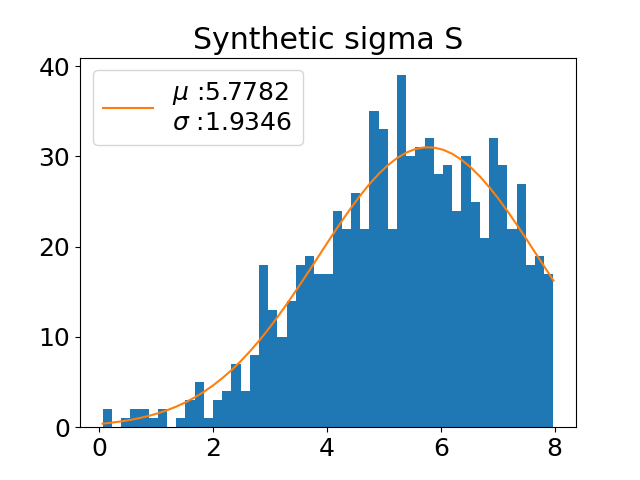

In [21]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)
    # return array,abin


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.4f}{linebreak}$\sigma$ :{std:.4f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))
    plt.legend()


s_array = S_map_deb.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()

s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
# s_array_ind = np.log(s_array_ind)

sigma_s_array_ind = sigma_s_array.copy()
sigma_s_array_ind = sigma_s_array_ind[::4]

syn_s_temp = np.random.normal(17,10,1000)
# syn_s_error= np.random.uniform(6,8,syn_s_temp.shape[0])
syn_s_error = np.random.normal(6,2,syn_s_temp.shape[0])

selector = (syn_s_temp < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error > 8)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan


df_s = pd.DataFrame({'syn_s': syn_s_temp,'syn_s_error':syn_s_error})
df_s = df_s.dropna()
gauss_fit(df_s['syn_s'],100)
plt.title('Synthetic S')
plt.show()

gauss_fit(s_array,100)
plt.title('Real S')
plt.show()

# plt.figure()
gauss_fit(sigma_s_array_ind,50)
plt.title('Real sigma S')
plt.show()

gauss_fit(syn_s_error,50)
plt.title('Synthetic sigma S')
plt.show()




Synthetic data for column density

-44.048376747645804


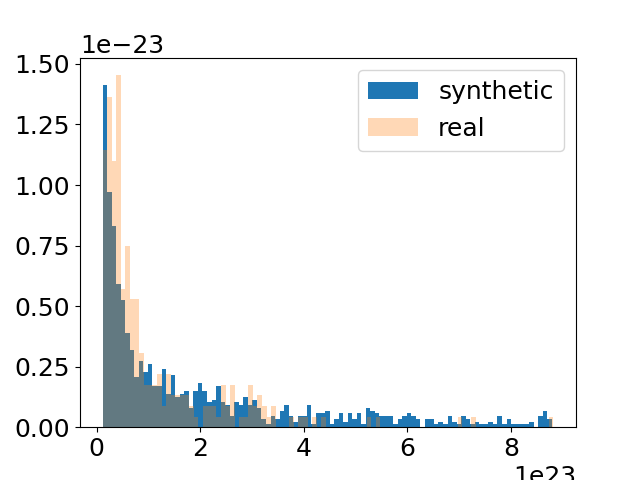

In [22]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

def powerlaw(x,*p):
    a,power = p
    return a*(x**(-1*power))

def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


def bin_generator(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    return array,abin

nh2_array = BlankedMapColumnDensity.data.flatten()
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
array_min = np.nanmin(nh2_array_ind)
nh2_array_ind = nh2_array_ind

nh2_min = np.nanmin(nh2_array_ind)
nh2_max = np.nanmax(nh2_array_ind)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)

hist, bin_edges = np.histogram(nh2_array_ind,nh2_bins)
temp_alpha = 1 + 1/(np.nanmean(np.log(nh2_array_ind/(np.nanmin(nh2_array_ind)))))
alpha = temp_alpha*0.65
print(1./(-1*alpha+1))
syn_nh2_temp = rndm(nh2_min,nh2_max, g=(-1*alpha+1), size=syn_s_temp.shape[0])
syn_nh2_error = syn_error(syn_nh2_temp)

plt.figure()
syn,syn_bin = bin_generator(syn_nh2_temp,100)
nh2,nh2_bin = bin_generator(nh2_array_ind,100)
plt.hist(syn,syn_bin,density=True,label='synthetic')
plt.hist(nh2,nh2_bin,density=True,alpha=0.3,label='real')
plt.legend()
plt.show()




Synthetic data for Pfrac

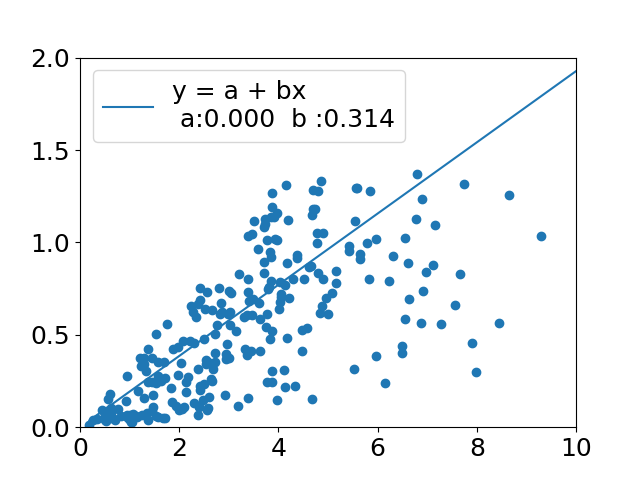

C:\Users\DELL\AppData\Local\Temp\ipykernel_12180\1719343926.py:42: RuntimeWarning: invalid value encountered in power
  syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))


In [23]:
def lin_fit(x, a, b):
    return a + b*x

p_array = BlankedMapPol.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()

p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
p_error_array_ind = p_error_array.copy()
p_error_array_ind = p_error_array_ind[::4]

p_min = np.nanmin(p_array_ind)
p_max = np.nanmax(p_array_ind)
p_bins = np.linspace(p_min, p_max, 150)

selector = ~np.isnan(p_array_ind)
p_array_fil = p_array_ind[selector]
p_error_array_fil = p_error_array_ind[selector]

# selector = p_array_fil < 10
# p_array_fil = p_array_fil[selector]
# p_error_array_fil = p_error_array_fil[selector]


param, param_cov = curve_fit(lin_fit, p_array_fil, p_error_array_fil)
FitFunc = lin_fit(p_bins,0,param[1]+0.1)
# print(param)
plt.figure()
plt.scatter(p_array_fil, p_error_array_fil)
plt.plot(p_bins,FitFunc,label='y = a + bx{br} a:{a:.3f}{linebreak}b :{b:.3f}'.format(br='\n',linebreak='  ',a =0,b=param[0]+0.1))
plt.legend()
plt.xlim(0,10)
plt.ylim(0,2)
plt.show()

######## case with error in power and pfrac, S and NH2 Error order = 0.01
syn_s= syn_s_temp + syn_s_error
syn_nh2 = syn_nh2_temp + syn_nh2_error

syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))


syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
syn_p = syn_p_temp+syn_p_error


####### case with error in pfrac, S and NH2 Error order = 0.0001-0.00001
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error
# syn_p_temp = 1e14*((syn_s)**(-1))*((syn_nh2)**(-0.5))
# syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
# syn_p = syn_p_temp+syn_p_error

######## case with error in power Error order = 0.01
# syn_s= syn_s_temp 
# syn_nh2 = syn_nh2_temp 
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp

######## case with error in power and S and NH2 Error order = 0.01
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp


# log_s = np.log10(syn_s)
# log_nh2 = np.log10(syn_nh2)
# log_p = np.log10(syn_p)

# plt.figure()
# plt.scatter(log_nh2,log_p)
# plt.show()


Doing bootstrap for the synthetic data

C:\Users\DELL\AppData\Local\Temp\ipykernel_12180\3722467916.py:2: RuntimeWarning: invalid value encountered in log10
  log_nh2 = np.log10(syn_nh2)


[[13.2818753  -0.89055615 -0.47268589]
 [13.53254105 -0.97790604 -0.47782381]
 [13.66006902 -0.92624168 -0.48638622]
 ...
 [14.27064678 -0.92387056 -0.51317591]
 [13.50287405 -0.92470437 -0.4797818 ]
 [13.50325847 -0.95412282 -0.47827148]]


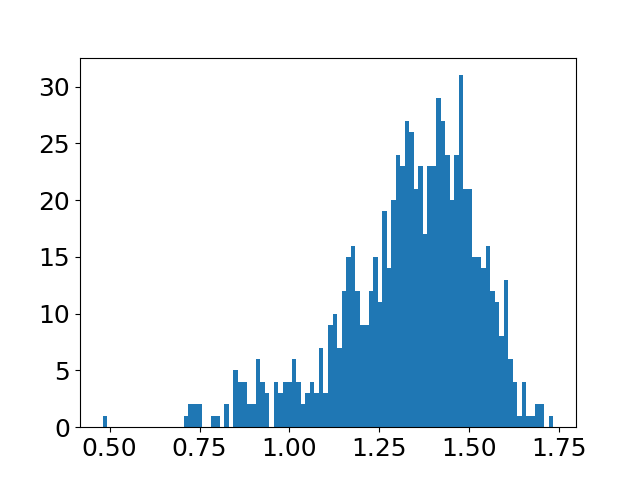

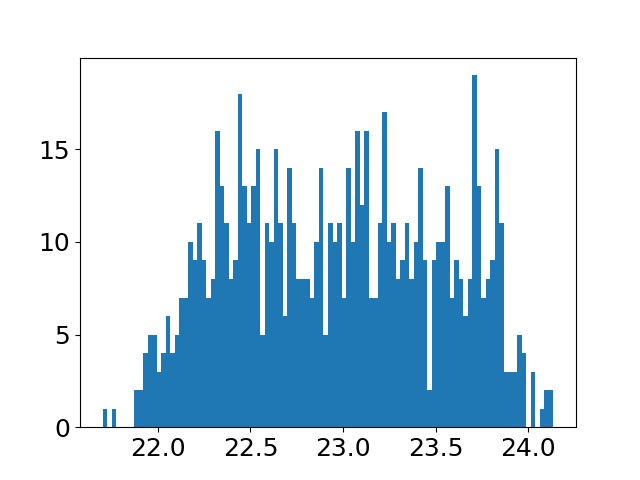

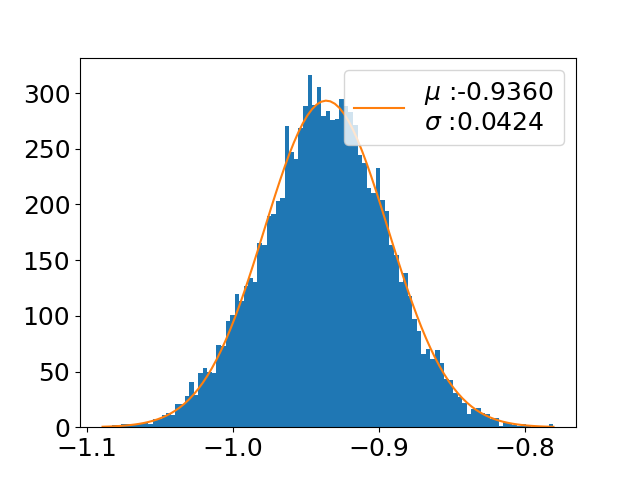

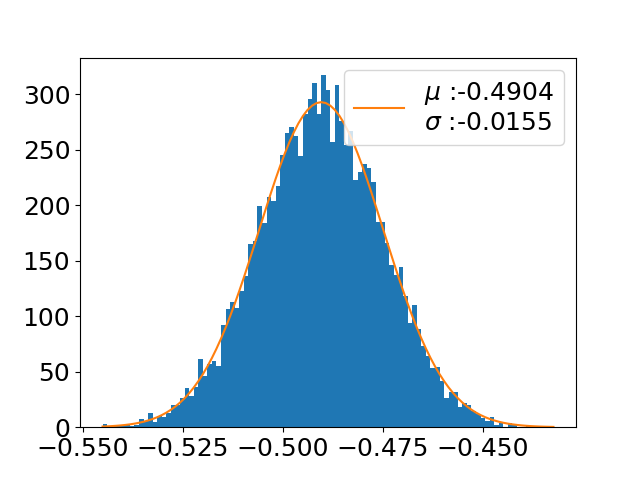

In [27]:
log_s = np.log10(syn_s)
log_nh2 = np.log10(syn_nh2)
log_p = np.log10(syn_p)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
    return param
    # return [param,np.sqrt(np.diag(param_cov))]



bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print(bootresult)
# print('sigma in aplha_S', np.std(bootresult[:,1]))
# print('sigma in aplha_nh2',np.std(bootresult[:,2]))


# plt.figure()
# plt.hist(bootresult[:,1],100)
# plt.show()
# plt.figure()
# plt.hist(bootresult[:,2],100)
# plt.show()
# # hist_plot(bootresult[:,1],50)
# # plt.show()

gauss_fit(bootresult[:,1],100)
plt.show()

gauss_fit(bootresult[:,2],100)
plt.show()


In [25]:
# from scipy.stats import bootstrap as bootstrapscipy

# res = bootstrapscipy(data=bootarr,statistic=curve_fitting,method='percentile')
# # fig, ax = plt.subplots()
# # ax.hist(res.bootstrap_distribution, bins=25)
# # ax.set_title('Bootstrap Distribution')
# # ax.set_xlabel('statistic value')
# # ax.set_ylabel('frequency')
# # plt.show()

In [26]:
bootresult[0,:,1]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

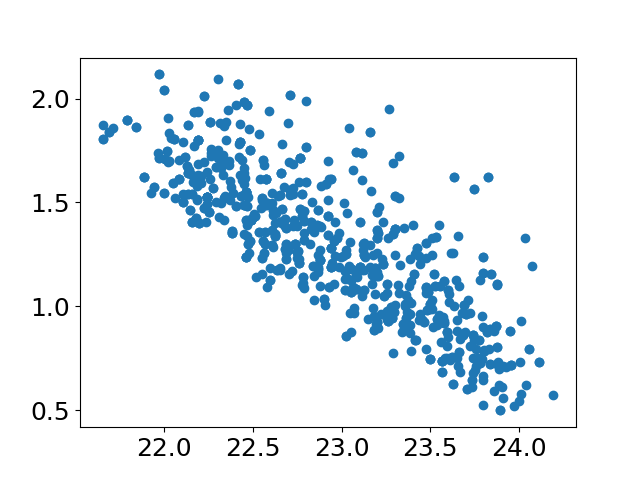

In [ ]:
bootresult = bootstrap(bootarr,bootnum=1,bootfunc=None)

plt.figure()
plt.scatter(bootarr[:,2],bootarr[:,0],"b")
plt.scatter(bootresult[0,:,2],bootresult[0,:,0],"r")
plt.show()

In [ ]:
bootstrap(np.array ( [[1,11],[2,22],[3,33],[4,44],[5,55],[6,66],[7,77],[8,88],[9,99],[10,110]] ),samples= 3,bootnum=5,bootfunc=None)


array([[[  9.,  99.],
        [  1.,  11.],
        [  3.,  33.]],

       [[ 10., 110.],
        [  8.,  88.],
        [ 10., 110.]],

       [[  2.,  22.],
        [  2.,  22.],
        [  1.,  11.]],

       [[  8.,  88.],
        [  7.,  77.],
        [  1.,  11.]],

       [[  6.,  66.],
        [  1.,  11.],
        [  1.,  11.]]])

In [ ]:
def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

df = pd.DataFrame({'syn_s': np.log10(syn_s),'syn_nh2':np.log10(syn_nh2),'syn_p':np.log10(syn_p)})
df = df.dropna()


p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df['syn_s'],df['syn_nh2']),df['syn_p'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])

C : 14.173754027018667
s index : -0.9996768526962478
nh2 index : -0.5037535188290263


C:\Users\DELL\AppData\Local\Temp\ipykernel_7580\3706261993.py:5: RuntimeWarning: invalid value encountered in log10
  df = pd.DataFrame({'syn_s': np.log10(syn_s),'syn_nh2':np.log10(syn_nh2),'syn_p':np.log10(syn_p)})


working with real data

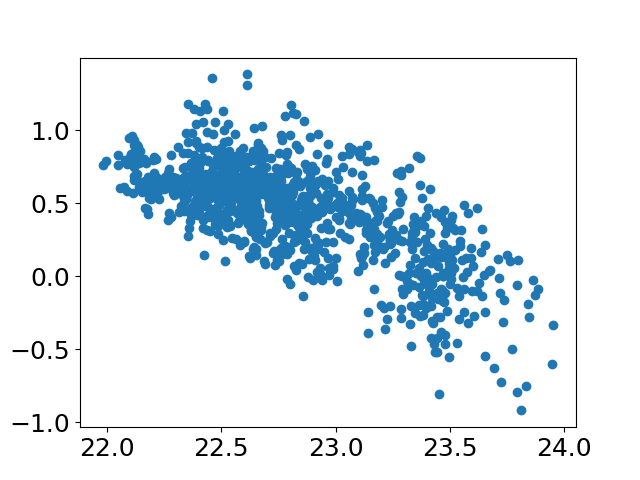

In [ ]:
def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


p_array = BlankedMapPol.data.flatten()
s_array = S_map_deb.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()
syn_nh2_error = syn_error(nh2_array)


log_s = np.log10(s_array)
log_nh2 = np.log10(nh2_array)
log_p = np.log10(p_array)

plt.figure()
plt.scatter(log_nh2,log_p)
plt.show()

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
# df_log = df_log.dropna()

# def DoubleParamFunc(X, a, b, c):
#     x,y = X
#     return a + b*x + c*y

# def curve_fitting(x):
#     param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
#     # return param
#     return np.sqrt(np.diag(param_cov))


# bootarr = np.array(df_log)
# print(bootarr.shape)
# bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
# print(bootresult)

In [ ]:

def lin_fit(x, a, b):
    return a + b*x


def single_curve_fitting(x):
    param, param_cov = curve_fit(lin_fit,x[:,0],x[:,1])
    # return param
    return np.sqrt(np.diag(param_cov))



df_log = pd.DataFrame({'logp': log_p,'logs':log_s})
df_log = df_log.dropna()
bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,bootnum = 100,bootfunc=single_curve_fitting)
print(bootresult)


# x = np.array([df_log['logs'],df_log['logp']])
# print(x)

# print(curve_fit(lin_fit,(x[0,:]),x[1,:]))

# print('error in alpha_s',np.nanstd(bootresult[:,1]))

[[0.01067233 0.01959404]
 [0.01044674 0.01913776]
 [0.0110933  0.02046983]
 [0.01210497 0.02229566]
 [0.01173078 0.02150089]
 [0.01114031 0.02052873]
 [0.0118643  0.02140281]
 [0.01222775 0.02248303]
 [0.01180918 0.02179315]
 [0.01087537 0.01950609]
 [0.01112616 0.01990845]
 [0.01177029 0.02093993]
 [0.01254244 0.02295439]
 [0.01067828 0.01940561]
 [0.01118389 0.02054074]
 [0.01331371 0.02367749]
 [0.01101908 0.01993021]
 [0.01178618 0.02121398]
 [0.01122526 0.02085451]
 [0.01209313 0.0219365 ]
 [0.01127363 0.02066405]
 [0.01145245 0.02096621]
 [0.01140239 0.02100313]
 [0.01125673 0.02048415]
 [0.01142093 0.02056158]
 [0.0116575  0.02126859]
 [0.01215543 0.02219803]
 [0.01210484 0.02206646]
 [0.01121525 0.02007111]
 [0.01226026 0.02198685]
 [0.0112119  0.02009923]
 [0.01095475 0.01973657]
 [0.01049664 0.01932116]
 [0.01155517 0.02061874]
 [0.0138811  0.0254953 ]
 [0.01145689 0.0209064 ]
 [0.01093455 0.01974221]
 [0.01135141 0.02072565]
 [0.01175121 0.02152258]
 [0.01153399 0.02145007]
